<a href="https://colab.research.google.com/github/Anoif01/Disruption_forecasting_in_Supply_Chain/blob/main/SupplyChain_disruption_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subject: Disruption forecasting in Supply Chain.

### 1. In this project, a public Supply Chain Graph dataset is used - SupplyGraph: A Benchmark Dataset for Supply Chain Planning using Graph Neural Networks.

Dataset Github link: https://github.com/CIOL-SUST/SupplyGraph

Citation:
@misc{wasi2024supplygraph,
      title={SupplyGraph: A Benchmark Dataset for Supply Chain Planning using Graph Neural Networks},
      author={Azmine Toushik Wasi and MD Shafikul Islam and Adipto Raihan Akib},
      year={2024},
      eprint={2401.15299},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}

### 2. Commonly used GNN models were tested, like GCN, GAT, SAGEConv, Chebnet. To compare the performance of graph models, I also used the BASELINE model, RNN.


### Author: Xiaohua LU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Personal_Project/SupplyGraph/Supply_Graph_Git')

Mounted at /content/drive


In [ ]:
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
TORCH = '2.3.0'

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html -q
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html -q
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html -q
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html -q
!pip install torch-geometric -q
# !pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
!pip install -q wandb
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
import datetime
import random
from argparse import Namespace
from typing import Callable, Optional
import pandas as pd
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from IPython.display import display
from matplotlib import pyplot as plt

from torch_geometric.nn import HeteroConv, GCNConv, GATConv, GATv2Conv, SAGEConv, ChebConv
from torch_geometric.data import (
    Data,
    HeteroData,
    Dataset,
    InMemoryDataset
)

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

# Read credentiels
from google.colab import userdata
WANDB_TOKEN = userdata.get('WANDB_KEY')

In [ ]:
seed = 100
def set_seed(seed):
  # Set available CUDA devices
  # This option is crucial for an multi-GPU device
  # os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
  # os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
  os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
  os.environ['PYTHONHASHSEED']=str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  torch.use_deterministic_algorithms(True)

## Load Data

### node index; edge index

In [ ]:
node_index_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Nodes/NodesIndex.csv'
node_type_group_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv'
node_type_plantstock_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Nodes/Nodes Type (Plant & Storage).csv'

edge_index_plant_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Edges/EdgesIndex/Edges (Plant).csv'
edge_index_group_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Edges/EdgesIndex/Edges (Product Group).csv'
edge_index_subgroup_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Edges/EdgesIndex/Edges (Product Sub-Group).csv'
edge_index_stock_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Edges/EdgesIndex/Edges (Storage Location).csv'

df_node_index = pd.read_csv(node_index_path, header=0)
df_node_type_group = pd.read_csv(node_type_group_path, header=0)
df_node_type_plantstock = pd.read_csv(node_type_plantstock_path, header=0)

df_edge_index_plant = pd.read_csv(edge_index_plant_path, header=0)
df_edge_index_group = pd.read_csv(edge_index_group_path, header=0)
df_edge_index_subgroup = pd.read_csv(edge_index_subgroup_path, header=0)
df_edge_index_stock = pd.read_csv(edge_index_stock_path, header=0)

In [ ]:
display(df_node_type_group.head(5))
print(df_node_type_group.shape)

display(df_node_type_plantstock.head(5))
print(df_node_type_plantstock.shape)

,Node,Group,Sub-Group
0,SOS008L02P,S,SOS
1,SOS005L04P,S,SOS
2,SOS003L04P,S,SOS
3,SOS002L09P,S,SOS
4,SOS001L12P,S,SOS


(41, 3)


,Node,Plant,Storage Location
0,POV002L09P,2120,2030.0
1,SOS001L12P,2120,2030.0
2,POP002L09P,2120,2030.0
3,POP001L12P,2120,2030.0
4,POP001L12P,2120,2030.0


(6545, 3)


In [ ]:
display(df_edge_index_plant.head(5))
print(df_edge_index_plant.shape)

display(df_edge_index_group.head(5))
print(df_edge_index_group.shape)

display(df_edge_index_subgroup.head(5))
print(df_edge_index_subgroup.shape)

display(df_edge_index_stock.head(5))
print(df_edge_index_stock.shape)

,Plant,node1,node2
0,1901,28,24
1,1903,22,24
2,1903,22,26
3,1903,22,31
4,1903,22,29


(1647, 3)


,node1,node2,GroupCode
0,0,1,S
1,0,2,S
2,0,3,S
3,0,4,S
4,0,5,S


(188, 3)


,node1,node2,SubGroupCode
0,0,1,SOS
1,0,2,SOS
2,0,3,SOS
3,0,4,SOS
4,0,5,SOS


(52, 3)


,Storage Location,node1,node2
0,130.0,28,24
1,330.0,1,3
2,330.0,1,2
3,330.0,1,5
4,330.0,1,4


(3046, 3)


### unit

In [ ]:
unit_delivery_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Unit/Delivery To distributor.csv'
unit_factory_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Unit/Factory Issue.csv'
unit_production_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Unit/Production .csv'
unit_sales_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Unit/Sales Order.csv'

df_unit_delivery = pd.read_csv(unit_delivery_path, header=0)
df_unit_factory = pd.read_csv(unit_factory_path, header=0)
df_unit_production = pd.read_csv(unit_production_path, header=0)
df_unit_sales = pd.read_csv(unit_sales_path, header=0)

In [ ]:
display(df_unit_delivery.head(3))
print(df_unit_delivery.shape)

display(df_unit_factory.head(3))
print(df_unit_factory.shape)

display(df_unit_production.head(3))
print(df_unit_production.shape)

display(df_unit_sales.head(3))
print(df_unit_sales.shape)

,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,455.0,2241.00,342.0,1698.000000,3816.000000,1555.0,69.0,23.000000,72.0,...,0,160.0,0.000000,0,0,0,0,0,0,0.0
1,2023-01-02 00:00:00,327.0,8286.00,1458.0,9240.000000,12683.000000,5324.0,66.0,60.000000,85.0,...,0,980.0,55.228958,0,0,0,0,0,0,0.0
2,2023-01-03 00:00:00,523.5,11279.75,1207.0,10290.445048,14731.166033,5393.5,24.0,42.832065,270.0,...,18,854.5,203.000000,0,0,0,0,0,0,0.0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,220.0,2598.0,287.0,2080.0,2748.0,1670.634,0.0,10.0,100.0,...,43,1341.0,200,0,0,0,0,0,0,0
1,2023-01-02 00:00:00,485.0,4982.0,1048.0,4640.0,7560.0,3676.000,0.0,60.0,88.0,...,0,427.0,46,0,0,0,0,0,0,0
2,2023-01-03 00:00:00,520.0,11175.0,719.0,10801.0,12661.0,6334.500,0.0,0.0,195.0,...,5,435.0,0,0,0,0,0,0,0,0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,1008,3008,0,2034,4016,1003,0,0,0,...,48,1000,0,0,0,0,0,0,0,0
1,2023-01-02 00:00:00,1014,6000,0,6000,7000,3500,0,0,154,...,0,300,0,0,0,0,0,25,0,0
2,2023-01-03 00:00:00,0,4012,0,5053,10000,8500,0,0,0,...,0,300,0,0,0,0,0,0,0,0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,1355.0,12594.0,1949.0,14556.000000,21394.0,8552.0,1159.0,100.0,348.0,...,25,1507.0,225.0,0,0,0,0,0,0,0
1,2023-01-02 00:00:00,338.0,11677.0,1842.0,13085.000000,17059.0,7207.0,502.0,160.0,160.0,...,0,602.0,109.0,0,0,0,0,0,0,0
2,2023-01-03 00:00:00,226.0,8551.0,1135.0,8573.107971,12178.0,4234.0,290.0,278.0,190.0,...,0,1363.0,100.0,0,0,0,0,12,0,0


(221, 42)


### weight

In [ ]:
weight_delivery_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Weight/Delivery to Distributor.csv'
weight_factory_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Weight/Factory Issue.csv'
weight_production_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Weight/Production .csv'
weight_sales_path = './SupplyGraph-main/Raw Dataset/Homogenoeus/Temporal Data/Weight/Sales Order .csv'

df_weight_delivery = pd.read_csv(weight_delivery_path, header=0)
df_weight_factory = pd.read_csv(weight_factory_path, header=0)
df_weight_production = pd.read_csv(weight_production_path, header=0)
df_weight_sales = pd.read_csv(weight_sales_path, header=0)

In [ ]:
display(df_weight_delivery.head(3))
print(df_weight_delivery.shape)

display(df_weight_factory.head(3))
print(df_weight_factory.shape)

display(df_weight_production.head(3))
print(df_weight_production.shape)

display(df_weight_sales.head(3))
print(df_weight_sales.shape)

,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,6.69760,41.2344,3.77568,28.11888,42.128640,17.16720,0.76176,0.253920,1.3104,...,0.00,0.960,0.000000,0,0,0,0.0,0.0,0,0.0
1,2023-01-02 00:00:00,4.81344,152.4624,16.09632,153.01440,140.020320,58.77696,0.72864,0.662400,1.5470,...,0.00,5.880,0.265099,0,0,0,0.0,0.0,0,0.0
2,2023-01-03 00:00:00,7.70592,207.5474,13.32528,170.40977,162.632073,59.54424,0.26496,0.472866,4.9140,...,0.45,5.127,0.974400,0,0,0,0.0,0.0,0,0.0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,3.2384,47.8032,3.16848,34.44480,30.33792,18.443799,0.0,0.1104,0,...,1.075,8.046,0.9600,0,0,0,0.0,0.0,0,0
1,2023-01-02 00:00:00,7.1392,91.6688,11.56992,76.83840,83.46240,40.583040,0.0,0.6624,0,...,0.000,2.562,0.2208,0,0,0,0.0,0.0,0,0
2,2023-01-03 00:00:00,7.6544,205.6200,7.93776,178.86456,139.77744,69.932880,0.0,0.0000,0,...,0.125,2.610,0.0000,0,0,0,0.0,0.0,0,0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,14.83776,55.3472,0.0,33.68304,44.33664,11.07312,0.0,0.0,0.0000,...,1.2,6.0,0.0,0,0,0,0.0,0.0,0,0
1,2023-01-02 00:00:00,14.92608,110.4000,0.0,99.36000,77.28000,38.64000,0.0,0.0,2.8028,...,0.0,1.8,0.0,0,0,0,0.0,0.6,0,0
2,2023-01-03 00:00:00,0.00000,73.8208,0.0,83.67768,110.40000,93.84000,0.0,0.0,0.0000,...,0.0,1.8,0.0,0,0,0,0.0,0.0,0,0


(221, 42)


,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
0,2023-01-01 00:00:00,19.94560,231.7296,21.51696,241.047360,236.18976,94.41408,12.79536,1.10400,6.3336,...,0.625,9.042,1.0800,0.0,0.0,0.0,0.0,0.000,0.0,0.0
1,2023-01-02 00:00:00,4.97536,214.8568,20.33568,216.687600,188.33136,79.56528,5.54208,1.76640,2.9120,...,0.000,3.612,0.5232,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2,2023-01-03 00:00:00,3.32672,157.3384,12.53040,141.970668,134.44512,46.74336,3.20160,3.06912,3.4580,...,0.000,8.178,0.4800,0.0,0.0,0.0,0.0,0.288,0.0,0.0


(221, 42)


## Data Processing


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
set_seed(seed)

time_steps = df_unit_production.shape[0]
node_features = []
y = []
hist = 3

# Get node features（time series）
for i in range(time_steps-hist-1):
    # Exclud timestamps
    # Using 3 days of production, sales, and delivery as attributs, predict the number of factories on day 4.
    node_features.append( np.concatenate( (df_unit_production.iloc[i:i+hist, 1:].to_numpy().flatten(), df_unit_sales.iloc[i:i+hist, 1:].to_numpy().flatten(), df_unit_delivery.iloc[i:i+hist, 1:].to_numpy().flatten()), axis=0))
    y.append(df_unit_factory.iloc[i+hist+1, 1:])

node_features = np.array(node_features)
y = np.array(y)

# Normalisation
scaler_x = MinMaxScaler()  # or StandardScaler()
scaler_y = MinMaxScaler()

# Reshape for scaler
n_nodes = 41
n_samples, n_nodes_features = node_features.shape
n_features = int(n_nodes_features/n_nodes)
node_features = node_features.reshape(-1, n_features)
y = y.reshape(-1, 1)

# Fit and transform
node_features = scaler_x.fit_transform(node_features)
y = scaler_y.fit_transform(y)

# Reshape back to original shape
node_features = node_features.reshape(n_nodes, n_samples, n_features)
y = y.reshape(n_nodes, n_samples, 1)

# Convert to torch.tensor
node_features = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
x = node_features

print(x.shape, y.shape)

torch.Size([41, 217, 9]) torch.Size([41, 217, 1])


In [ ]:
print(node_features.shape, y.shape)

torch.Size([41, 217, 9]) torch.Size([41, 217, 1])


## Baseline RNN

In [ ]:
# x = x.permute(0, 2, 1)  # (41, 221, 3)

# Assuming that each time step is a sample, we can split by the time step
time_steps = x.shape[1]
train_size = int(time_steps * 0.8)
val_size = int(time_steps * 0.1)
test_size = time_steps - train_size - val_size

# Data sets splitting
x_train = x[:, :train_size, :]
y_train = y[:, :train_size, :]

x_val = x[:, train_size:train_size + val_size, :]
y_val = y[:, train_size:train_size + val_size, :]

x_test = x[:, train_size + val_size:, :]
y_test = y[:, train_size + val_size:, :]

print(f"Train shape: x={x_train.shape}, y={y_train.shape}")
print(f"Validation shape: x={x_val.shape}, y={y_val.shape}")
print(f"Test shape: x={x_test.shape}, y={y_test.shape}")

Train shape: x=torch.Size([41, 173, 9]), y=torch.Size([41, 173, 1])
Validation shape: x=torch.Size([41, 21, 9]), y=torch.Size([41, 21, 1])
Test shape: x=torch.Size([41, 23, 9]), y=torch.Size([41, 23, 1])


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

set_seed(seed)

# Create dataset
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

# Create data loader
batch_size = 41
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class TwoStack_RNN(nn.Module):
    def __init__(self, input_size, h1, h2, output_size, dp=0.2):
        super(TwoStack_RNN, self).__init__()
        self.rnn1 = nn.RNN(input_size, h1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(h1)
        self.dropout1 = nn.Dropout(dp)
        self.rnn2 = nn.RNN(h1, h2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(h2)
        self.dropout2 = nn.Dropout(dp)
        self.fc = nn.Linear(h2, output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        # print(out.shape)
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)  # 批量归一化
        out = F.relu(out)
        out = self.dropout1(out)

        out, _ = self.rnn2(out)
        # print(out.shape)
        out = self.bn2(out.transpose(1, 2)).transpose(1, 2)  # 批量归一化
        out = F.relu(out)
        out = self.dropout2(out)

        out = self.fc(out)
        return out

def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            # print(outputs.shape)
            # print(y_batch.shape)
            batch_loss = criterion(outputs, y_batch)
            loss += batch_loss.item()

    loss /= len(data_loader)
    return loss

def test_model(model, criterion, data_loader, scaler_y=None):
    model.eval()
    loss = 0.0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            batch_loss = criterion(outputs, y_batch)
            loss += batch_loss.item()

            # Truncate negative outputs to zero
            outputs = torch.clamp(outputs, min=0)

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    print(all_outputs.shape,all_targets.shape )
    if scaler_y is not None:
        all_outputs = scaler_y.inverse_transform(all_outputs.squeeze())
        all_targets = scaler_y.inverse_transform(all_targets.squeeze())

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    # Make sure the input is a numpy array
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape

In [ ]:
wandb.finish()
wb_log = True

set_seed(seed)

# Model parameters
input_size = x_train.shape[2]
h1, h2 = 8, 8  # Hidden layer size
output_size = 1
dp = 0.2
lr=0.0001
num_epochs = 1000
patience = 10

# Register model parameters to WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = batch_size
    args.drop=dp
    args.h1 = h1
    args.h2 = h2
    args.modelname = 'TwoStack_RNN'  # TCN 'LSTM', 'GRU', 'BiGRU'  #"TCN-BS%d-Step%d_kt%d_drop%.3f"%(BS,hist,kt,p)
    args.data = 'Temp features'
    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    wandb.init(project='SupplyGraph_v2', name=args.modelname, config=vars(args))


# Initialize the model, loss func and optimiser
model = TwoStack_RNN(input_size, h1, h2, output_size, dp)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# Move data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TwoStack_RNN(
  (rnn1): RNN(9, 8, batch_first=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (rnn2): RNN(8, 8, batch_first=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


Epoch 0, Epoch Tume: 0, Train Loss: 0.3825222849845886, Validation Loss: 0.06604833900928497
Epoch 1, Epoch Tume: 0, Train Loss: 0.37841299176216125, Validation Loss: 0.0647951066493988
Epoch 2, Epoch Tume: 0, Train Loss: 0.38036027550697327, Validation Loss: 0.06350225955247879
Epoch 3, Epoch Tume: 0, Train Loss: 0.3776232600212097, Validation Loss: 0.06197816878557205
Epoch 4, Epoch Tume: 0, Train Loss: 0.3593893349170685, Validation Loss: 0.06025652214884758
Epoch 5, Epoch Tume: 0, Train Loss: 0.38512852787971497, Validation Loss: 0.05851102992892265
Epoch 6, Epoch Tume: 0, Train Loss: 0.38450855016708374, Validation Loss: 0.05684454366564751
Epoch 7, Epoch Tume: 0, Train Loss: 0.36206111311912537, Validation Loss: 0.05523999035358429
Epoch 8, Epoch Tume: 0, Train Loss: 0.37003228068351746, Validation Loss: 0.05367333069443703
Epoch 9, Epoch Tume: 0, Train Loss: 0.3610289692878723, Validation Loss: 0.052225254476070404
Epoch 10, Epoch Tume: 0, Train Loss: 0.37141212821006775, Valida

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█▇▇▇▄██▄▅▄▆▃▅▅▄▄▃▅▂▂▃▄▂▂▃▃▂▁▂
val loss,██▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▂▂▂▃▄▅▅
Best VAL Loss,0.04562
Test Loss,0.05611
Test MAE,880.68414
Test MAPE,8873714483200.0
Test MSE,4615402.5
Test RMSE,2148.34888
epoch,29


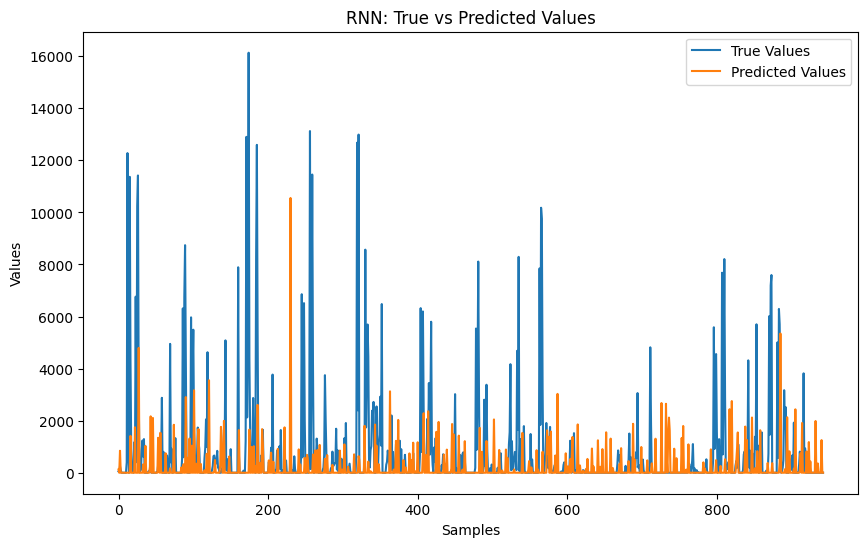

In [ ]:
# Ensure that experimental results can be reproduced
set_seed(seed)

# Early stop settings
best_val_loss = np.inf
n = 0
for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # if epoch % 10 == 0:
        val_loss = evaluate_model(model, criterion, val_loader)

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

         # Early stop mechanism
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            n = 0
            print(f'Epoch {epoch}, Epoch Tume: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            n += 1

        if n >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

# Test best model and compute performances
test_loss, test_outputs, test_targets = test_model(best_model, criterion, test_loader, scaler_y=scaler_y)
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)
print(f'Test Loss: {test_loss}')

# Register to WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()

# Visualisation of predictions
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('RNN: True vs Predicted Values')
plt.show()

## GCN

In [ ]:
# Dataset settings
num_nodes = node_features.shape[0]
num_time_steps = node_features.shape[1]
num_features = node_features.shape[2]

# Split in an 8:1:1 ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_steps = int(num_time_steps * train_ratio)
val_steps = int(num_time_steps * val_ratio)
test_steps = num_time_steps - train_steps - val_steps

train_idx = torch.arange(0, train_steps * num_nodes)
val_idx = torch.arange(train_steps * num_nodes, (train_steps + val_steps) * num_nodes)
test_idx = torch.arange((train_steps + val_steps) * num_nodes, num_time_steps * num_nodes)

print(len(train_idx), len(val_idx), len(test_idx))

7093 861 943


In [ ]:
def create_heterodata(x, y, edge_index_group, edge_index_subgroup, edge_index_plant, edge_index_stock):
    # Creating a HeteroData Object
    data = HeteroData()

    # Add node features and labels
    num_nodes = x.shape[0] # 41
    num_time_steps = x.shape[1] # 221
    num_features = x.shape[2] # 3

    print(x.shape)

    # Adapting to PyTorch Geometric input requirements
    x_reshaped = x.reshape(num_nodes * num_time_steps, num_features)
    y_reshaped = y.reshape(num_nodes * num_time_steps, 1)
    data['product'].x = x_reshaped
    data['product'].y = y_reshaped

    # Add edges (group)
    data['product', 'groupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_group['node1'].values, df_edge_index_group['node2'].values], dtype=torch.long)

    # Add edges（subgroup）
    data['product', 'subgroupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_subgroup['node1'].values, df_edge_index_subgroup['node2'].values], dtype=torch.long)

    # Add edges（plant）
    data['product', 'plant', 'product'].edge_index = torch.tensor(
        [df_edge_index_plant['node1'].values, df_edge_index_plant['node2'].values], dtype=torch.long)

    # Add edges（storage location）
    data['product', 'store_location', 'product'].edge_index = torch.tensor(
        [df_edge_index_stock['node1'].values, df_edge_index_stock['node2'].values], dtype=torch.long)

    return data

# Create mask for registring the sample ids in train, valid and test
def create_mask(idx, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[idx] = True
    return mask

set_seed(seed)

# Create HeteroData objects for dataset
data = create_heterodata(x, y, df_edge_index_group, df_edge_index_subgroup, df_edge_index_plant, df_edge_index_stock)

# Setting up training, validation and test indexes
data['product'].train_idx = train_idx
data['product'].val_idx = val_idx
data['product'].test_idx = test_idx

# Creating masks
num_samples = num_nodes * num_time_steps
train_mask = create_mask(train_idx, num_samples)
val_mask = create_mask(val_idx, num_samples)
test_mask = create_mask(test_idx, num_samples)

data['product'].train_mask = train_mask
data['product'].val_mask = val_mask
data['product'].test_mask = test_mask

print(data)

torch.Size([41, 217, 9])
HeteroData(
  product={
    x=[8897, 9],
    y=[8897, 1],
    train_idx=[7093],
    val_idx=[861],
    test_idx=[943],
    train_mask=[8897],
    val_mask=[8897],
    test_mask=[8897],
  },
  (product, groupe, product)={ edge_index=[2, 188] },
  (product, subgroupe, product)={ edge_index=[2, 52] },
  (product, plant, product)={ edge_index=[2, 1647] },
  (product, store_location, product)={ edge_index=[2, 3046] }
)


<ipython-input-16-f89abcf39360>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data['product', 'groupe', 'product'].edge_index = torch.tensor(


In [ ]:
# HeteroConv allows defining different convolution operations for each edge type.
# There are four edge types: grouped_with, subgrouped_with, plant_related and stored_with.
class HeteroGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(HeteroGCN, self).__init__()

        # First HeteroConv convolution layer
        self.conv1 = HeteroConv({
            ('product', 'groupe', 'product'): GCNConv(in_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): GCNConv(in_channels, hidden_channels),
            ('product', 'plant', 'product'): GCNConv(in_channels, hidden_channels),
            ('product', 'store_location', 'product'): GCNConv(in_channels, hidden_channels),
        }, aggr='max')

        # Second HeteroConv convolution layer
        self.conv2 = HeteroConv({
            ('product', 'groupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'plant', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'store_location', 'product'): GCNConv(hidden_channels, hidden_channels),
        }, aggr='min')

        # Third HeteroConv convolution layer
        self.conv3 = HeteroConv({
            ('product', 'groupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'plant', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'store_location', 'product'): GCNConv(hidden_channels, hidden_channels),
        }, aggr='sum')

        # Forth HeteroConv convolution layer
        self.conv4 = HeteroConv({
            ('product', 'groupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'plant', 'product'): GCNConv(hidden_channels, hidden_channels),
            ('product', 'store_location', 'product'): GCNConv(hidden_channels, hidden_channels),
        }, aggr='mean')

        ## Fifth HeteroConv convolution layer
        # self.conv5 = HeteroConv({
        #     ('product', 'groupe', 'product'): GCNConv(hidden_channels, hidden_channels),
        #     ('product', 'subgroupe', 'product'): GCNConv(hidden_channels, hidden_channels),
        #     ('product', 'plant', 'product'): GCNConv(hidden_channels, hidden_channels),
        #     ('product', 'store_location', 'product'): GCNConv(hidden_channels, hidden_channels),
        # }, aggr='softmax')

        # Fully connected layer
        self.ln = nn.Linear(hidden_channels, out_channels, bias=True)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        # relu
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Third layer
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Forth layer
        x_dict = self.conv4(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Fifth layer
        # x_dict = self.conv5(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        out = self.ln(x_dict['product'])
        return out

In [ ]:
wandb.finish()
wb_log = True

# Ensure that experimental results can be reproduced
set_seed(seed)

# Model parameters setting
num_epochs = 1000
in_channels = 9
hidden_channels = 128
out_channels = 1
patience = 10
lr = 0.0001
ln_bias = True

# Register HeteroConv types
agg_order = 'max_min_sum_mean'
# agg_order = 'max_min_mean_sum'
# agg_order = 'max_min_sum'
# agg_order = 'max_min_mean'

# Write in WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = None
    args.drop = None
    args.h1 = hidden_channels
    args.h2 = hidden_channels
    args.modelname = 'Hetero_GCN'
    args.data = 'SupplyGraph'
    args.ln_bias = ln_bias
    args.agg_order = agg_order

    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    run_name = 'Hetero_4GCN'
    # run_name = 'Hetero_3GCN'
    # run_name = 'Hetero_2GCN'

    wandb.init(project='SupplyGraph_v2', name=run_name, config=vars(args))

model = HeteroGCN(in_channels, hidden_channels, out_channels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anoif. Use `wandb login --relogin` to force relogin


HeteroGCN(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (conv3): HeteroConv(num_relations=4)
  (conv4): HeteroConv(num_relations=4)
  (ln): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Epoch Time: 0, Train Loss: 0.013851053081452847, Validation Loss: 0.006045123096555471
Epoch 1, Epoch Time: 0, Train Loss: 0.013804998248815536, Validation Loss: 0.005976526066660881
Epoch 2, Epoch Time: 0, Train Loss: 0.013761034235358238, Validation Loss: 0.005907838698476553
Epoch 3, Epoch Time: 0, Train Loss: 0.013717581517994404, Validation Loss: 0.0058389450423419476
Epoch 4, Epoch Time: 0, Train Loss: 0.013674391433596611, Validation Loss: 0.005769514478743076
Epoch 5, Epoch Time: 0, Train Loss: 0.013631559908390045, Validation Loss: 0.005699639208614826
Epoch 6, Epoch Time: 0, Train Loss: 0.013588975183665752, Validation Loss: 0.005629576276987791
Epoch 7, Epoch Time: 0, Train Loss: 0.013546820729970932, Validation Loss: 0.00555854756385088
Epoch 8, Epoch Time: 0, Train Loss: 0.01350513193756342, Validation Loss: 0.005487506743520498
Epoch 9, Epoch Time: 0, Train Loss: 0.013464098796248436, Validation Loss: 0.005416932050138712
Epoch 10, Epoch Time: 0, Train Loss: 0.01

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
val loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,0.0005
Test MAE,753.49713
Test MAPE,21723470233600.0
Test MSE,1725136.5
Test RMSE,1313.44446
epoch,100
time,0


Test Loss: 0.0004998900112695992


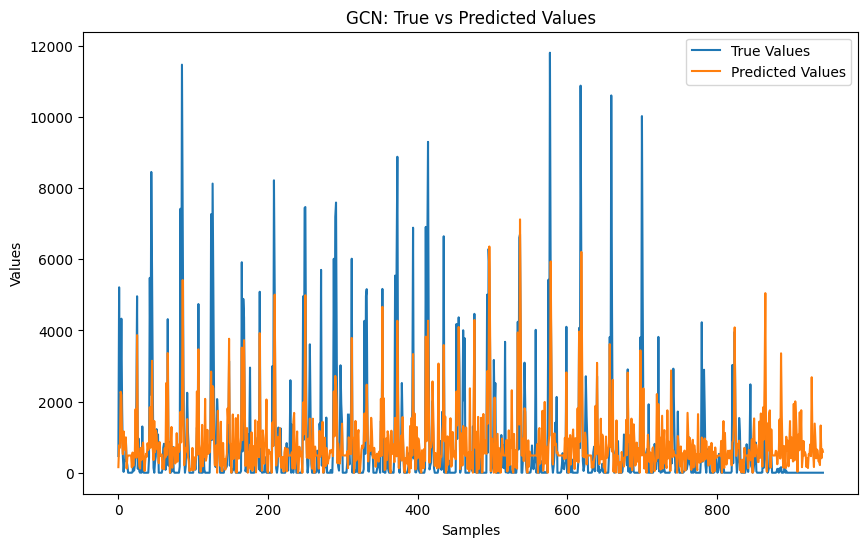

In [ ]:
def train_model(model, criterion, optimizer, data, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        optimizer.zero_grad()
        outputs = model(data.x_dict, data.edge_index_dict)

        outputs = outputs.squeeze()
        # print(outputs.shape)

        train_outputs = outputs[data['product'].train_mask]
        train_labels = data['product'].y[data['product'].train_mask]

        loss = criterion(train_outputs.squeeze(), train_labels.squeeze())
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        val_loss, _, _ = evaluate_model(model, criterion, data, mask_type='val_mask')

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early Stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            epochs_without_improvement = 0
            print(f'Epoch {epoch}, Epoch Time: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

    return best_model

def evaluate_model(model, criterion, data, mask_type='valid_mask'):
    model.eval()
    with torch.no_grad():
        outputs = model(data.x_dict, data.edge_index_dict)
        mask = data['product'][mask_type]
        eval_outputs = outputs[mask]
        eval_labels = data['product'].y[mask]
        loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

        all_outputs = eval_outputs.cpu().numpy()
        all_targets = eval_labels.cpu().numpy()

    return loss.item(), all_outputs, all_targets

def test_model(model, criterion, data_loader, scaler_y=None, mask_type='test_mask'):
    with torch.no_grad():
      outputs = model(data.x_dict, data.edge_index_dict)
      mask = data['product'][mask_type]
      eval_outputs = outputs[mask]
      eval_labels = data['product'].y[mask]
      loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

      # Truncate negative numbers to zero
      eval_outputs = torch.clamp(eval_outputs, min=0)

      all_outputs = eval_outputs.cpu().numpy()
      all_targets = eval_labels.cpu().numpy()

      print('Here',all_outputs.shape )

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if scaler_y is not None:
        # Convert the dimension of y from (n, ) to (n, 1)
        all_outputs = np.expand_dims(all_outputs, axis=1)
        all_targets = np.expand_dims(all_targets, axis=1)
        # print(all_outputs.shape, all_targets.shape)

        all_outputs = scaler_y.inverse_transform(all_outputs)
        all_targets = scaler_y.inverse_transform(all_targets)

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape

set_seed(seed)

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)

# Train model
best_model = train_model(model, criterion, optimizer, data, num_epochs=100, patience=patience)

# Test model
test_loss, test_outputs, test_targets = test_model(best_model, criterion, data, scaler_y=scaler_y, mask_type='test_mask')

# Compute metrics
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)

# Write in WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()

print(f'Test Loss: {test_loss}')

# Viz predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('GCN: True vs Predicted Values')
plt.show()

In [ ]:
np.save('gcn_pred.npy', test_outputs)
np.save('gcn_gt.npy', test_targets)

## GAT

In [ ]:
# Dataset settings
num_nodes = node_features.shape[0]
num_time_steps = node_features.shape[1]
num_features = node_features.shape[2]

# Split in an 8:1:1 ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_steps = int(num_time_steps * train_ratio)
val_steps = int(num_time_steps * val_ratio)
test_steps = num_time_steps - train_steps - val_steps

train_idx = torch.arange(0, train_steps * num_nodes)
val_idx = torch.arange(train_steps * num_nodes, (train_steps + val_steps) * num_nodes)
test_idx = torch.arange((train_steps + val_steps) * num_nodes, num_time_steps * num_nodes)

print(len(train_idx), len(val_idx), len(test_idx))

7093 861 943


In [ ]:
def create_heterodata(x, y, edge_index_group, edge_index_subgroup, edge_index_plant, edge_index_stock):
    # Creating a HeteroData Object
    data = HeteroData()

    # Add node features and labels
    num_nodes = x.shape[0] # 41
    num_time_steps = x.shape[1] # 221
    num_features = x.shape[2] # 3

    print(x.shape)

    # Adapting to PyTorch Geometric input requirements
    x_reshaped = x.reshape(num_nodes * num_time_steps, num_features)
    y_reshaped = y.reshape(num_nodes * num_time_steps, 1)
    data['product'].x = x_reshaped
    data['product'].y = y_reshaped

    # Add edges (group)
    data['product', 'groupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_group['node1'].values, df_edge_index_group['node2'].values], dtype=torch.long)

    # Add edges（subgroup）
    data['product', 'subgroupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_subgroup['node1'].values, df_edge_index_subgroup['node2'].values], dtype=torch.long)

    # Add edges（plant）
    data['product', 'plant', 'product'].edge_index = torch.tensor(
        [df_edge_index_plant['node1'].values, df_edge_index_plant['node2'].values], dtype=torch.long)

    # Add edges（storage location）
    data['product', 'store_location', 'product'].edge_index = torch.tensor(
        [df_edge_index_stock['node1'].values, df_edge_index_stock['node2'].values], dtype=torch.long)

    return data

# Create mask for registring the sample ids in train, valid and test
def create_mask(idx, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[idx] = True
    return mask

set_seed(seed)

# Create HeteroData objects for dataset
data = create_heterodata(x, y, df_edge_index_group, df_edge_index_subgroup, df_edge_index_plant, df_edge_index_stock)

# Setting up training, validation and test indexes
data['product'].train_idx = train_idx
data['product'].val_idx = val_idx
data['product'].test_idx = test_idx

# Creating masks
num_samples = num_nodes * num_time_steps
train_mask = create_mask(train_idx, num_samples)
val_mask = create_mask(val_idx, num_samples)
test_mask = create_mask(test_idx, num_samples)

data['product'].train_mask = train_mask
data['product'].val_mask = val_mask
data['product'].test_mask = test_mask

print(data)

torch.Size([41, 217, 9])
HeteroData(
  product={
    x=[8897, 9],
    y=[8897, 1],
    train_idx=[7093],
    val_idx=[861],
    test_idx=[943],
    train_mask=[8897],
    val_mask=[8897],
    test_mask=[8897],
  },
  (product, groupe, product)={ edge_index=[2, 188] },
  (product, subgroupe, product)={ edge_index=[2, 52] },
  (product, plant, product)={ edge_index=[2, 1647] },
  (product, store_location, product)={ edge_index=[2, 3046] }
)


In [ ]:
class HeteroGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(HeteroGAT, self).__init__()

        # First HeteroConv convolution layer
        self.conv1 = HeteroConv({
            ('product', 'groupe', 'product'): GATConv(in_channels, hidden_channels // heads, heads),
            ('product', 'subgroupe', 'product'): GATConv(in_channels, hidden_channels // heads, heads),
            ('product', 'plant', 'product'): GATConv(in_channels, hidden_channels // heads, heads),
            ('product', 'store_location', 'product'): GATConv(in_channels, hidden_channels // heads, heads),
        }, aggr='min')

        # Second HeteroConv convolution layer
        self.conv2 = HeteroConv({
            ('product', 'groupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
            ('product', 'subgroupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
            ('product', 'plant', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
            ('product', 'store_location', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        }, aggr='min')

        # # Third HeteroConv convolution layer
        # self.conv3 = HeteroConv({
        #     ('product', 'groupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'subgroupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'plant', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'store_location', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        # }, aggr='max')


        # # Fourth HeteroConv convolution layer
        # self.conv4 = HeteroConv({
        #     ('product', 'groupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'subgroupe', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'plant', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'store_location', 'product'): GATConv(hidden_channels, hidden_channels // heads, heads),
        # }, aggr='mean')

        # Fully connect output layer
        self.ln = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Third layer
        # x_dict = self.conv3(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        #  # Fourth layer
        # x_dict = self.conv4(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Output layer
        out = self.ln(x_dict['product'])
        return out

In [ ]:
wandb.finish()
wb_log = False

# Ensure that experimental results can be reproduced
set_seed(seed)

# Model parameters setting
num_epochs = 1000
in_channels = 9
hidden_channels = 128
out_channels = 1
heads = 8  # Number of attention heads in GAT
patience = 10
lr = 0.001

ln_bias = True

# Try different combinations of HeteroConv types
# agg_order = 'max_min_sum_mean'
# agg_order = 'max_min_mean_sum'
# agg_order = 'max_min_sum'
# agg_order = 'max_min_mean'
# agg_order = 'min_min_min'
# agg_order = 'min_min_max'
# agg_order = 'mean_mean'
# agg_order = 'max_min'
# agg_order = 'max_max'
agg_order = 'min_min' # the best try!!
# agg_order = 'min'

# Write in WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = None
    args.drop = None
    args.head = heads
    args.h1 = hidden_channels
    args.h2 = hidden_channels

    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    args.modelname = 'Hetero_GAT'
    args.data = 'SupplyGraph'
    args.ln_bias = ln_bias
    args.agg_order = agg_order

    # run_name = 'Hetero_4GAT'
    # run_name = 'Hetero_3GAT'
    run_name = 'Hetero_2GAT'
    # run_name = 'Hetero_1GAT'

    wandb.init(project='SupplyGraph_v2', name=run_name, config=vars(args))

# Create model, loss func and optimizer
model = HeteroGAT(in_channels, hidden_channels, out_channels, heads)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

HeteroGAT(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (ln): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Epoch Time: 0, Train Loss: 0.013220756314694881, Validation Loss: 0.0044827647507190704
Epoch 4, Epoch Time: 0, Train Loss: 0.013140013441443443, Validation Loss: 0.0044754487462341785
Epoch 5, Epoch Time: 0, Train Loss: 0.013110557571053505, Validation Loss: 0.004451202694326639
Epoch 6, Epoch Time: 0, Train Loss: 0.013077815063297749, Validation Loss: 0.004430186934769154
Epoch 7, Epoch Time: 0, Train Loss: 0.013042598031461239, Validation Loss: 0.004413300659507513
Epoch 8, Epoch Time: 0, Train Loss: 0.013003761880099773, Validation Loss: 0.004399111028760672
Epoch 9, Epoch Time: 0, Train Loss: 0.012962703593075275, Validation Loss: 0.004379277117550373
Epoch 10, Epoch Time: 0, Train Loss: 0.01291746273636818, Validation Loss: 0.004353065509349108
Epoch 11, Epoch Time: 0, Train Loss: 0.012867179699242115, Validation Loss: 0.004323520697653294
Epoch 12, Epoch Time: 0, Train Loss: 0.012812448665499687, Validation Loss: 0.0042931255884468555
Epoch 13, Epoch Time: 0, Train Loss

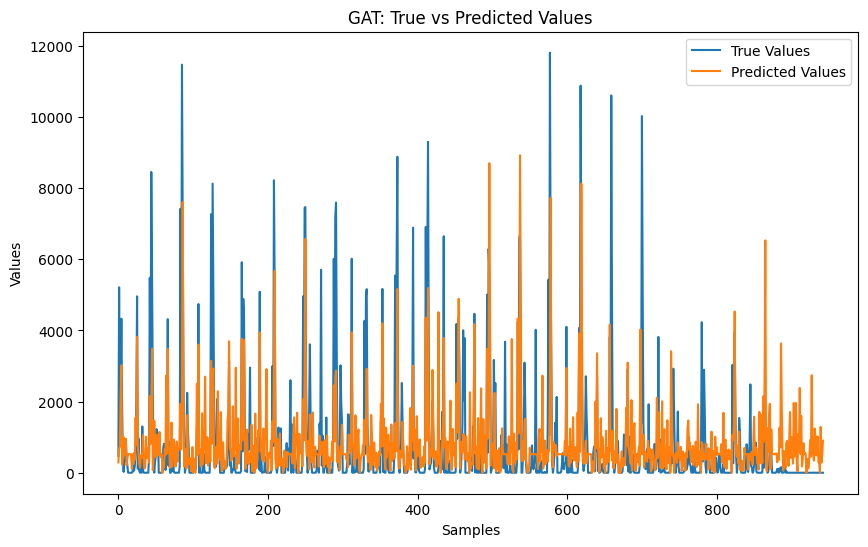

In [ ]:
def train_model(model, criterion, optimizer, data, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        optimizer.zero_grad()
        outputs = model(data.x_dict, data.edge_index_dict)

        train_outputs = outputs[data['product'].train_mask]
        train_labels = data['product'].y[data['product'].train_mask]

        loss = criterion(train_outputs.squeeze(), train_labels.squeeze())
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        val_loss, _, _ = evaluate_model(model, criterion, data, mask_type='val_mask')

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            epochs_without_improvement = 0
            print(f'Epoch {epoch}, Epoch Time: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

    return best_model

def evaluate_model(model, criterion, data, mask_type='valid_mask'):
    model.eval()
    with torch.no_grad():
        outputs = model(data.x_dict, data.edge_index_dict)
        mask = data['product'][mask_type]
        eval_outputs = outputs[mask]
        eval_labels = data['product'].y[mask]
        loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

        all_outputs = eval_outputs.cpu().numpy()
        all_targets = eval_labels.cpu().numpy()

    return loss.item(), all_outputs, all_targets

def test_model(model, criterion, data_loader, scaler_y=None, mask_type='test_mask'):
    with torch.no_grad():
      outputs = model(data.x_dict, data.edge_index_dict)
      mask = data['product'][mask_type]
      eval_outputs = outputs[mask]
      eval_labels = data['product'].y[mask]
      loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

      # Truncate negative numbers to zero
      eval_outputs = torch.clamp(eval_outputs, min=0)

      all_outputs = eval_outputs.cpu().numpy()
      all_targets = eval_labels.cpu().numpy()

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if scaler_y is not None:
        # Convert the dimension of y from (n, ) to (n, 1).
        all_outputs = np.expand_dims(all_outputs, axis=1)
        all_targets = np.expand_dims(all_targets, axis=1)
        # print(all_outputs.shape, all_targets.shape)

        all_outputs = scaler_y.inverse_transform(all_outputs)
        all_targets = scaler_y.inverse_transform(all_targets)

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape


# Ensure that experimental results can be reproduced
set_seed(seed)

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)

# Train model
best_model = train_model(model, criterion, optimizer, data, num_epochs=num_epochs, patience=patience)

# Test model
test_loss, test_outputs, test_targets = test_model(best_model, criterion, data, scaler_y=scaler_y, mask_type='test_mask')
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)

# Write metric in WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()
print(f'Test Loss: {test_loss}')

# Viz predictions
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('GAT: True vs Predicted Values')
plt.show()

## GATv2


In [ ]:
# Dataset settings
num_nodes = node_features.shape[0]
num_time_steps = node_features.shape[1]
num_features = node_features.shape[2]

# Split in an 8:1:1 ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_steps = int(num_time_steps * train_ratio)
val_steps = int(num_time_steps * val_ratio)
test_steps = num_time_steps - train_steps - val_steps

train_idx = torch.arange(0, train_steps * num_nodes)
val_idx = torch.arange(train_steps * num_nodes, (train_steps + val_steps) * num_nodes)
test_idx = torch.arange((train_steps + val_steps) * num_nodes, num_time_steps * num_nodes)

print(len(train_idx), len(val_idx), len(test_idx))

7093 861 943


In [ ]:
def create_heterodata(x, y, edge_index_group, edge_index_subgroup, edge_index_plant, edge_index_stock):
    # Creating a HeteroData Object
    data = HeteroData()

    # Add node features and labels
    num_nodes = x.shape[0] # 41
    num_time_steps = x.shape[1] # 221
    num_features = x.shape[2] # 3

    print(x.shape)

    # Adapting to PyTorch Geometric input requirements
    x_reshaped = x.reshape(num_nodes * num_time_steps, num_features)
    y_reshaped = y.reshape(num_nodes * num_time_steps, 1)
    data['product'].x = x_reshaped
    data['product'].y = y_reshaped

    # Add edges (group)
    data['product', 'groupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_group['node1'].values, df_edge_index_group['node2'].values], dtype=torch.long)

    # Add edges（subgroup）
    data['product', 'subgroupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_subgroup['node1'].values, df_edge_index_subgroup['node2'].values], dtype=torch.long)

    # Add edges（plant）
    data['product', 'plant', 'product'].edge_index = torch.tensor(
        [df_edge_index_plant['node1'].values, df_edge_index_plant['node2'].values], dtype=torch.long)

    # Add edges（storage location）
    data['product', 'store_location', 'product'].edge_index = torch.tensor(
        [df_edge_index_stock['node1'].values, df_edge_index_stock['node2'].values], dtype=torch.long)

    return data

# Create mask for registring the sample ids in train, valid and test
def create_mask(idx, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[idx] = True
    return mask

set_seed(seed)

# Create HeteroData objects for dataset
data = create_heterodata(x, y, df_edge_index_group, df_edge_index_subgroup, df_edge_index_plant, df_edge_index_stock)

# Setting up training, validation and test indexes
data['product'].train_idx = train_idx
data['product'].val_idx = val_idx
data['product'].test_idx = test_idx

# Creating masks
num_samples = num_nodes * num_time_steps
train_mask = create_mask(train_idx, num_samples)
val_mask = create_mask(val_idx, num_samples)
test_mask = create_mask(test_idx, num_samples)

data['product'].train_mask = train_mask
data['product'].val_mask = val_mask
data['product'].test_mask = test_mask

print(data)

torch.Size([41, 217, 9])
HeteroData(
  product={
    x=[8897, 9],
    y=[8897, 1],
    train_idx=[7093],
    val_idx=[861],
    test_idx=[943],
    train_mask=[8897],
    val_mask=[8897],
    test_mask=[8897],
  },
  (product, groupe, product)={ edge_index=[2, 188] },
  (product, subgroupe, product)={ edge_index=[2, 52] },
  (product, plant, product)={ edge_index=[2, 1647] },
  (product, store_location, product)={ edge_index=[2, 3046] }
)


In [ ]:
class HeteroGATv2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(HeteroGATv2, self).__init__()

        # First HeteroConv convolution layer
        self.conv1 = HeteroConv({
            ('product', 'groupe', 'product'): GATv2Conv(in_channels, hidden_channels // heads, heads),
            ('product', 'subgroupe', 'product'): GATv2Conv(in_channels, hidden_channels // heads, heads),
            ('product', 'plant', 'product'): GATv2Conv(in_channels, hidden_channels // heads, heads),
            ('product', 'store_location', 'product'): GATv2Conv(in_channels, hidden_channels // heads, heads),
        }, aggr='min')

        # # Second HeteroConv convolution layer
        # self.conv2 = HeteroConv({
        #     ('product', 'groupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'subgroupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'plant', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'store_location', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        # }, aggr='min')

        # # Third HeteroConv convolution layer
        # self.conv3 = HeteroConv({
        #     ('product', 'groupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'subgroupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'plant', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'store_location', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        # }, aggr='sum')

        # # Fourth HeteroConv convolution layer
        # self.conv4 = HeteroConv({
        #     ('product', 'groupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'subgroupe', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'plant', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        #     ('product', 'store_location', 'product'): GATv2Conv(hidden_channels, hidden_channels // heads, heads),
        # }, aggr='mean')

        # Fully connected layer
        self.ln = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Second layer
        # x_dict = self.conv2(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Third layer
        # x_dict = self.conv3(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Fourth layer
        # x_dict = self.conv4(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Output layer
        out = self.ln(x_dict['product'])
        return out

In [ ]:
wandb.finish()
wb_log = False

# Ensure that experimental results can be reproduced
set_seed(seed)

# Model parameters setting
num_epochs = 1000
in_channels = 9
hidden_channels = 128
out_channels = 1
heads = 8  # Number of attention heads in GAT
patience = 10
lr = 0.0001

ln_bias = True
# Try different combinations of HeteroConv types
agg_order = 'min'
# agg_order = 'min_min'
# agg_order = 'max_min'
# agg_order = 'mean_mean'
# agg_order = 'max_min_sum_mean'
# agg_order = 'max_min_sum'
# agg_order = 'max_min_mean'

# Write in WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = None
    args.drop = None
    args.h1 = hidden_channels
    args.h2 = hidden_channels
    args.modelname = 'Hetero_GATv2'
    args.data = 'SupplyGraph'
    args.ln_bias = ln_bias
    args.agg_order = agg_order

    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    run_name = 'Hetero_2GATv2'
    # run_name = 'Hetero_3GATv2'
    # run_name = 'Hetero_4GATv2'

    wandb.init(project='SupplyGraph_v2', name=run_name, config=vars(args))

model = HeteroGATv2(in_channels, hidden_channels, out_channels, heads)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

HeteroGATv2(
  (conv1): HeteroConv(num_relations=4)
  (ln): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Epoch Time: 0, Train Loss: 0.024316735565662384, Validation Loss: 0.011232640594244003
Epoch 1, Epoch Time: 0, Train Loss: 0.024270301684737206, Validation Loss: 0.011195177212357521
Epoch 2, Epoch Time: 0, Train Loss: 0.024223962798714638, Validation Loss: 0.011157820001244545
Epoch 3, Epoch Time: 0, Train Loss: 0.02417771704494953, Validation Loss: 0.011120568960905075
Epoch 4, Epoch Time: 0, Train Loss: 0.024131562560796738, Validation Loss: 0.011083423160016537
Epoch 5, Epoch Time: 0, Train Loss: 0.024085503071546555, Validation Loss: 0.011046379804611206
Epoch 6, Epoch Time: 0, Train Loss: 0.02403954416513443, Validation Loss: 0.011009441688656807
Epoch 7, Epoch Time: 0, Train Loss: 0.023993685841560364, Validation Loss: 0.010972610674798489
Epoch 8, Epoch Time: 0, Train Loss: 0.023947933688759804, Validation Loss: 0.010935861617326736
Epoch 9, Epoch Time: 0, Train Loss: 0.0239022858440876, Validation Loss: 0.010899212211370468
Epoch 10, Epoch Time: 0, Train Loss: 0.02385

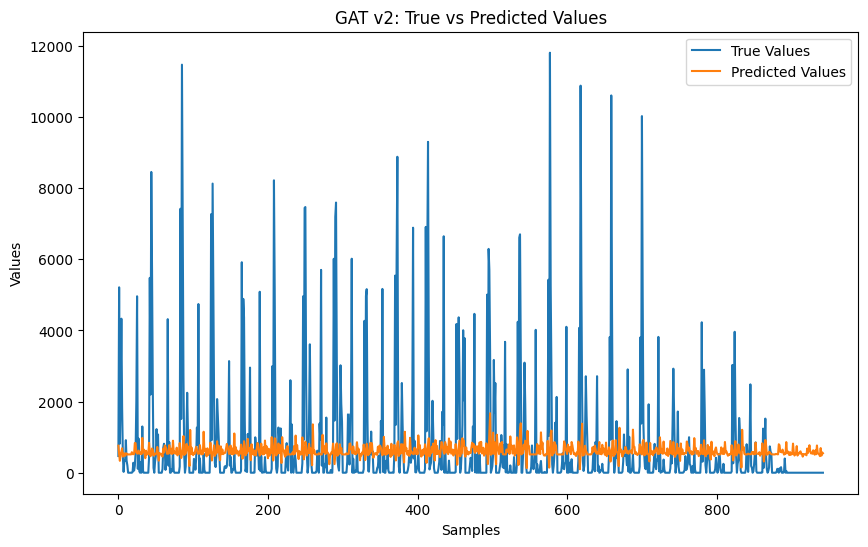

In [ ]:
def train_model(model, criterion, optimizer, data, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        optimizer.zero_grad()
        outputs = model(data.x_dict, data.edge_index_dict)

        train_outputs = outputs[data['product'].train_mask]
        train_labels = data['product'].y[data['product'].train_mask]

        loss = criterion(train_outputs.squeeze(), train_labels.squeeze())
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        val_loss, _, _ = evaluate_model(model, criterion, data, mask_type='val_mask')

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early Stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            epochs_without_improvement = 0
            print(f'Epoch {epoch}, Epoch Time: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

    return best_model

def evaluate_model(model, criterion, data, mask_type='valid_mask'):
    model.eval()
    with torch.no_grad():
        outputs = model(data.x_dict, data.edge_index_dict)
        mask = data['product'][mask_type]
        eval_outputs = outputs[mask]
        eval_labels = data['product'].y[mask]
        loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

        all_outputs = eval_outputs.cpu().numpy()
        all_targets = eval_labels.cpu().numpy()

    return loss.item(), all_outputs, all_targets

def test_model(model, criterion, data_loader, scaler_y=None, mask_type='test_mask'):
    with torch.no_grad():
      outputs = model(data.x_dict, data.edge_index_dict)
      mask = data['product'][mask_type]
      eval_outputs = outputs[mask]
      eval_labels = data['product'].y[mask]
      loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

      eval_outputs = torch.clamp(eval_outputs, min=0)

      all_outputs = eval_outputs.cpu().numpy()
      all_targets = eval_labels.cpu().numpy()

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if scaler_y is not None:
        # Convert the dimension of y from (n, ) to (n, 1).
        all_outputs = np.expand_dims(all_outputs, axis=1)
        all_targets = np.expand_dims(all_targets, axis=1)
        # print(all_outputs.shape, all_targets.shape)

        all_outputs = scaler_y.inverse_transform(all_outputs)
        all_targets = scaler_y.inverse_transform(all_targets)

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape

# Ensure that experimental results can be reproduced
set_seed(seed)

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)

# Train model
best_model = train_model(model, criterion, optimizer, data, num_epochs=num_epochs, patience=patience)

# Test model
test_loss, test_outputs, test_targets = test_model(best_model, criterion, data, scaler_y=scaler_y, mask_type='test_mask')
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)

# Write metric in WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()

print(f'Test Loss: {test_loss}')

# Viz predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('GAT v2: True vs Predicted Values')
plt.show()

## GraphSage


In [ ]:
# Dataset settings
num_nodes = node_features.shape[0]
num_time_steps = node_features.shape[1]
num_features = node_features.shape[2]

# Split in an 8:1:1 ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_steps = int(num_time_steps * train_ratio)
val_steps = int(num_time_steps * val_ratio)
test_steps = num_time_steps - train_steps - val_steps

train_idx = torch.arange(0, train_steps * num_nodes)
val_idx = torch.arange(train_steps * num_nodes, (train_steps + val_steps) * num_nodes)
test_idx = torch.arange((train_steps + val_steps) * num_nodes, num_time_steps * num_nodes)

print(len(train_idx), len(val_idx), len(test_idx))

7093 861 943


In [ ]:
def create_heterodata(x, y, edge_index_group, edge_index_subgroup, edge_index_plant, edge_index_stock):
    # Creating a HeteroData Object
    data = HeteroData()

    # Add node features and labels
    num_nodes = x.shape[0] # 41
    num_time_steps = x.shape[1] # 221
    num_features = x.shape[2] # 3

    print(x.shape)

    # Adapting to PyTorch Geometric input requirements
    x_reshaped = x.reshape(num_nodes * num_time_steps, num_features)
    y_reshaped = y.reshape(num_nodes * num_time_steps, 1)
    data['product'].x = x_reshaped
    data['product'].y = y_reshaped

    # Add edges (group)
    data['product', 'groupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_group['node1'].values, df_edge_index_group['node2'].values], dtype=torch.long)

    # Add edges（subgroup）
    data['product', 'subgroupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_subgroup['node1'].values, df_edge_index_subgroup['node2'].values], dtype=torch.long)

    # Add edges（plant）
    data['product', 'plant', 'product'].edge_index = torch.tensor(
        [df_edge_index_plant['node1'].values, df_edge_index_plant['node2'].values], dtype=torch.long)

    # Add edges（storage location）
    data['product', 'store_location', 'product'].edge_index = torch.tensor(
        [df_edge_index_stock['node1'].values, df_edge_index_stock['node2'].values], dtype=torch.long)

    return data

# Create mask for registring the sample ids in train, valid and test
def create_mask(idx, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[idx] = True
    return mask

set_seed(seed)

# Create HeteroData objects for dataset
data = create_heterodata(x, y, df_edge_index_group, df_edge_index_subgroup, df_edge_index_plant, df_edge_index_stock)

# Setting up training, validation and test indexes
data['product'].train_idx = train_idx
data['product'].val_idx = val_idx
data['product'].test_idx = test_idx

# Creating masks
num_samples = num_nodes * num_time_steps
train_mask = create_mask(train_idx, num_samples)
val_mask = create_mask(val_idx, num_samples)
test_mask = create_mask(test_idx, num_samples)

data['product'].train_mask = train_mask
data['product'].val_mask = val_mask
data['product'].test_mask = test_mask

print(data)

torch.Size([41, 217, 9])
HeteroData(
  product={
    x=[8897, 9],
    y=[8897, 1],
    train_idx=[7093],
    val_idx=[861],
    test_idx=[943],
    train_mask=[8897],
    val_mask=[8897],
    test_mask=[8897],
  },
  (product, groupe, product)={ edge_index=[2, 188] },
  (product, subgroupe, product)={ edge_index=[2, 52] },
  (product, plant, product)={ edge_index=[2, 1647] },
  (product, store_location, product)={ edge_index=[2, 3046] }
)


In [ ]:
class HeteroGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(HeteroGraphSAGE, self).__init__()

        # First HeteroConv convolution layer
        self.conv1 = HeteroConv({
            ('product', 'groupe', 'product'): SAGEConv(in_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): SAGEConv(in_channels, hidden_channels),
            ('product', 'plant', 'product'): SAGEConv(in_channels, hidden_channels),
            ('product', 'store_location', 'product'): SAGEConv(in_channels, hidden_channels),
        }, aggr='max')

        # Second HeteroConv convolution layer
        self.conv2 = HeteroConv({
            ('product', 'groupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'plant', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'store_location', 'product'): SAGEConv(hidden_channels, hidden_channels),
        }, aggr='min')

        # Third HeteroConv convolution layer
        self.conv3 = HeteroConv({
            ('product', 'groupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'subgroupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'plant', 'product'): SAGEConv(hidden_channels, hidden_channels),
            ('product', 'store_location', 'product'): SAGEConv(hidden_channels, hidden_channels),
        }, aggr='min')

        # # Fourth HeteroConv convolution layer
        # self.conv4 = HeteroConv({
        #     ('product', 'groupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
        #     ('product', 'subgroupe', 'product'): SAGEConv(hidden_channels, hidden_channels),
        #     ('product', 'plant', 'product'): SAGEConv(hidden_channels, hidden_channels),
        #     ('product', 'store_location', 'product'): SAGEConv(hidden_channels, hidden_channels),
        # }, aggr='sum')

        # Fully connected layer
        self.ln = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Third layer
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Fourth layer
        # x_dict = self.conv4(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Output layer
        out = self.ln(x_dict['product'])
        return out

In [ ]:
wandb.finish()
wb_log = True

# Ensure that experimental results can be reproduced
set_seed(seed)

# Model parameters setting
num_epochs = 1000
in_channels = 9
hidden_channels = 64
out_channels = 1
patience = 20
lr = 0.0001

ln_bias = True

# Try different combinations of HeteroConv types
# agg_order = 'max_min_sum_mean'
# agg_order = 'max_min_mean_sum'
# agg_order = 'max_min_sum'
agg_order = 'max_min_min' # Best try!!
# agg_order = 'max_min_min_sum'
# agg_order = 'min_min_min'
# agg_order = 'max_min'
# agg_order = 'mean_mean'
# agg_order = 'max_min_mean'

# Write in WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = None
    args.drop = None
    args.h1 = hidden_channels
    args.h2 = hidden_channels
    args.modelname = 'Hetero_SageConv'
    args.data = 'SupplyGraph'
    args.ln_bias = ln_bias
    args.agg_order = agg_order

    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    # run_name = 'Hetero_2SageConv'
    run_name = 'Hetero_3SageConv'
    # run_name = 'Hetero_4SageConv'

    wandb.init(project='SupplyGraph_v2', name=run_name, config=vars(args))

model = HeteroGraphSAGE(in_channels, hidden_channels, out_channels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


HeteroGraphSAGE(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (conv3): HeteroConv(num_relations=4)
  (ln): Linear(in_features=64, out_features=1, bias=True)
)


Epoch 0, Epoch Time: 0, Train Loss: 0.017173465341329575, Validation Loss: 0.010915282182395458
Epoch 1, Epoch Time: 0, Train Loss: 0.017160886898636818, Validation Loss: 0.01089883130043745
Epoch 2, Epoch Time: 0, Train Loss: 0.017148330807685852, Validation Loss: 0.010882403701543808
Epoch 3, Epoch Time: 0, Train Loss: 0.01713579334318638, Validation Loss: 0.010865996591746807
Epoch 4, Epoch Time: 0, Train Loss: 0.017123278230428696, Validation Loss: 0.01084961462765932
Epoch 5, Epoch Time: 0, Train Loss: 0.017110781744122505, Validation Loss: 0.0108332559466362
Epoch 6, Epoch Time: 0, Train Loss: 0.017098305746912956, Validation Loss: 0.010816921480000019
Epoch 7, Epoch Time: 0, Train Loss: 0.01708585023880005, Validation Loss: 0.010800612159073353
Epoch 8, Epoch Time: 0, Train Loss: 0.017073415219783783, Validation Loss: 0.010784326121211052
Epoch 9, Epoch Time: 0, Train Loss: 0.01706100068986416, Validation Loss: 0.01076806802302599
Epoch 10, Epoch Time: 0, Train Loss: 0.017048608

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,███▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁
val loss,██▇▇▇▆▆▅▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Best VAL Loss,0.00379
Test Loss,0.00067
Test MAE,917.54877
Test MAPE,29708589465600.0
Test MSE,2332141.75
Test RMSE,1527.13513
epoch,671


Test Loss: 0.0006733600166626275


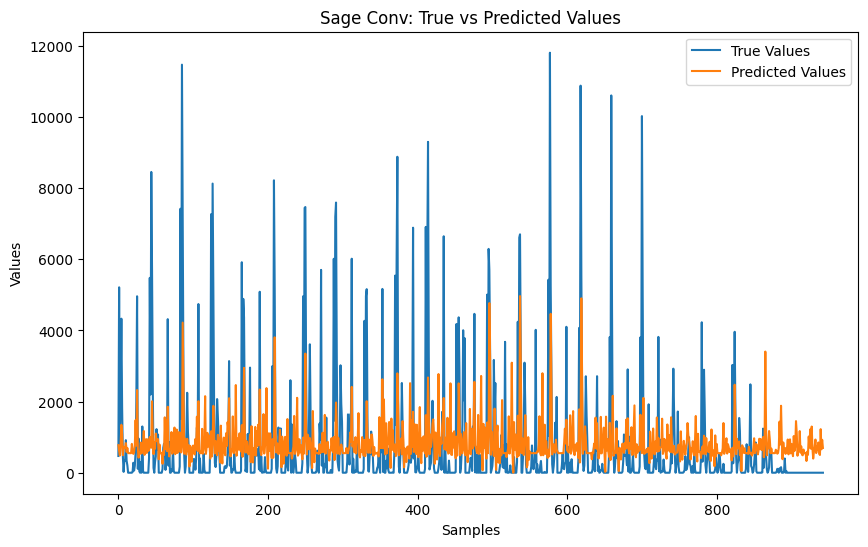

In [ ]:
def train_model(model, criterion, optimizer, data, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        optimizer.zero_grad()
        outputs = model(data.x_dict, data.edge_index_dict)

        train_outputs = outputs[data['product'].train_mask]
        train_labels = data['product'].y[data['product'].train_mask]

        loss = criterion(train_outputs.squeeze(), train_labels.squeeze())
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        val_loss, _, _ = evaluate_model(model, criterion, data, mask_type='val_mask')

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early Stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            epochs_without_improvement = 0
            print(f'Epoch {epoch}, Epoch Time: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

    return best_model

def evaluate_model(model, criterion, data, mask_type='valid_mask'):
    model.eval()
    with torch.no_grad():
        outputs = model(data.x_dict, data.edge_index_dict)
        mask = data['product'][mask_type]
        eval_outputs = outputs[mask]
        eval_labels = data['product'].y[mask]
        loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

        all_outputs = eval_outputs.cpu().numpy()
        all_targets = eval_labels.cpu().numpy()

    return loss.item(), all_outputs, all_targets

def test_model(model, criterion, data_loader, scaler_y=None, mask_type='test_mask'):
    with torch.no_grad():
      outputs = model(data.x_dict, data.edge_index_dict)
      mask = data['product'][mask_type]
      eval_outputs = outputs[mask]
      eval_labels = data['product'].y[mask]
      loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

      eval_outputs = torch.clamp(eval_outputs, min=0)

      all_outputs = eval_outputs.cpu().numpy()
      all_targets = eval_labels.cpu().numpy()

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if scaler_y is not None:
        all_outputs = np.expand_dims(all_outputs, axis=1)
        all_targets = np.expand_dims(all_targets, axis=1)
        # print(all_outputs.shape, all_targets.shape)

        all_outputs = scaler_y.inverse_transform(all_outputs)
        all_targets = scaler_y.inverse_transform(all_targets)

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape

set_seed(seed)

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)

# Train model
best_model = train_model(model, criterion, optimizer, data, num_epochs=num_epochs, patience=patience)

# Test model
test_loss, test_outputs, test_targets = test_model(best_model, criterion, data, scaler_y=scaler_y, mask_type='test_mask')
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)

# Write metrics in WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()
print(f'Test Loss: {test_loss}')

# Viz predictions
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('Sage Conv: True vs Predicted Values')
plt.show()

## ChebNet


In [ ]:
# Dataset settings
num_nodes = node_features.shape[0]
num_time_steps = node_features.shape[1]
num_features = node_features.shape[2]

# Split in an 8:1:1 ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_steps = int(num_time_steps * train_ratio)
val_steps = int(num_time_steps * val_ratio)
test_steps = num_time_steps - train_steps - val_steps

train_idx = torch.arange(0, train_steps * num_nodes)
val_idx = torch.arange(train_steps * num_nodes, (train_steps + val_steps) * num_nodes)
test_idx = torch.arange((train_steps + val_steps) * num_nodes, num_time_steps * num_nodes)

print(len(train_idx), len(val_idx), len(test_idx))

7093 861 943


In [ ]:
def create_heterodata(x, y, edge_index_group, edge_index_subgroup, edge_index_plant, edge_index_stock):
    # Creating a HeteroData Object
    data = HeteroData()

    # Add node features and labels
    num_nodes = x.shape[0] # 41
    num_time_steps = x.shape[1] # 221
    num_features = x.shape[2] # 3

    print(x.shape)

    # Adapting to PyTorch Geometric input requirements
    x_reshaped = x.reshape(num_nodes * num_time_steps, num_features)
    y_reshaped = y.reshape(num_nodes * num_time_steps, 1)
    data['product'].x = x_reshaped
    data['product'].y = y_reshaped

    # Add edges (group)
    data['product', 'groupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_group['node1'].values, df_edge_index_group['node2'].values], dtype=torch.long)

    # Add edges（subgroup）
    data['product', 'subgroupe', 'product'].edge_index = torch.tensor(
        [df_edge_index_subgroup['node1'].values, df_edge_index_subgroup['node2'].values], dtype=torch.long)

    # Add edges（plant）
    data['product', 'plant', 'product'].edge_index = torch.tensor(
        [df_edge_index_plant['node1'].values, df_edge_index_plant['node2'].values], dtype=torch.long)

    # Add edges（storage location）
    data['product', 'store_location', 'product'].edge_index = torch.tensor(
        [df_edge_index_stock['node1'].values, df_edge_index_stock['node2'].values], dtype=torch.long)

    return data

# Create mask for registring the sample ids in train, valid and test
def create_mask(idx, size):
    mask = torch.zeros(size, dtype=torch.bool)
    mask[idx] = True
    return mask

set_seed(seed)

# Create HeteroData objects for dataset
data = create_heterodata(x, y, df_edge_index_group, df_edge_index_subgroup, df_edge_index_plant, df_edge_index_stock)

# Setting up training, validation and test indexes
data['product'].train_idx = train_idx
data['product'].val_idx = val_idx
data['product'].test_idx = test_idx

# Creating masks
num_samples = num_nodes * num_time_steps
train_mask = create_mask(train_idx, num_samples)
val_mask = create_mask(val_idx, num_samples)
test_mask = create_mask(test_idx, num_samples)

data['product'].train_mask = train_mask
data['product'].val_mask = val_mask
data['product'].test_mask = test_mask

print(data)

torch.Size([41, 217, 9])
HeteroData(
  product={
    x=[8897, 9],
    y=[8897, 1],
    train_idx=[7093],
    val_idx=[861],
    test_idx=[943],
    train_mask=[8897],
    val_mask=[8897],
    test_mask=[8897],
  },
  (product, groupe, product)={ edge_index=[2, 188] },
  (product, subgroupe, product)={ edge_index=[2, 52] },
  (product, plant, product)={ edge_index=[2, 1647] },
  (product, store_location, product)={ edge_index=[2, 3046] }
)


In [ ]:
class HeteroChebNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=2):
        super(HeteroChebNet, self).__init__()

        # First HeteroConv convolution layer
        self.conv1 = HeteroConv({
            ('product', 'groupe', 'product'): ChebConv(in_channels, hidden_channels[0], K),
            ('product', 'subgroupe', 'product'): ChebConv(in_channels, hidden_channels[0], K),
            ('product', 'plant', 'product'): ChebConv(in_channels, hidden_channels[0], K),
            ('product', 'store_location', 'product'): ChebConv(in_channels, hidden_channels[0], K),
        }, aggr='max')

        # Second HeteroConv convolution layer
        self.conv2 = HeteroConv({
            ('product', 'groupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'subgroupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'plant', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'store_location', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        }, aggr='min')

         # Third HeteroConv convolution layer
        self.conv3 = HeteroConv({
            ('product', 'groupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'subgroupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'plant', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
            ('product', 'store_location', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        }, aggr='sum')

        #  # Fourth HeteroConv convolution layer
        # self.conv4 = HeteroConv({
        #     ('product', 'groupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        #     ('product', 'subgroupe', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        #     ('product', 'plant', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        #     ('product', 'store_location', 'product'): ChebConv(hidden_channels[0], hidden_channels[1], K),
        # }, aggr='mean')

        # Fully connected layer
        self.ln = nn.Linear(hidden_channels[1], out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Third layer
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # # Fourth layer
        # x_dict = self.conv4(x_dict, edge_index_dict)
        # x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Output layer
        out = self.ln(x_dict['product'])
        return out

In [ ]:
wandb.finish()
wb_log = True

# Ensure that experimental results can be reproduced
set_seed(seed)

# Model parameters setting
num_epochs = 1000
in_channels = 9
hidden_channels = [128, 128]
out_channels = 1
patience = 20
lr = 0.0001
K = 2 # Order of Chebyshev polynomials for fitting graph convolutions

ln_bias = True

# Try different combinations of HeteroConv types
# agg_order = 'max_min_sum_mean'
# agg_order = 'max_min_mean_sum'
agg_order = 'max_min_sum' # Best try!!!
# agg_order = 'max_min'
# agg_order = 'mean_mean'
# agg_order = 'max_min_mean'

# Write in WB
if wb_log:
    wandb.login(key=WANDB_TOKEN)
    args = Namespace()
    args.BS = None
    args.drop = None
    args.K = K
    args.h1 = hidden_channels
    args.h2 = hidden_channels
    args.modelname = 'Hetero_ChebNet'
    args.data = 'SupplyGraph'
    args.ln_bias = ln_bias
    args.agg_order = agg_order

    args.num_epochs = num_epochs
    args.lr = lr
    args.patience = patience

    # run_name = 'Hetero_2ChebNet'
    run_name = 'Hetero_3ChebNet'
    # run_name = 'Hetero_4ChebNet'

    wandb.init(project='SupplyGraph_v2', name=run_name, config=vars(args))

model = HeteroChebNet(in_channels, hidden_channels, out_channels, K=K)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


HeteroChebNet(
  (conv1): HeteroConv(num_relations=4)
  (conv2): HeteroConv(num_relations=4)
  (conv3): HeteroConv(num_relations=4)
  (ln): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 0, Epoch Time: 0, Train Loss: 0.028165308758616447, Validation Loss: 0.01447838731110096
Epoch 1, Epoch Time: 0, Train Loss: 0.027735348790884018, Validation Loss: 0.014136990532279015
Epoch 2, Epoch Time: 0, Train Loss: 0.027308830991387367, Validation Loss: 0.013796987012028694
Epoch 3, Epoch Time: 0, Train Loss: 0.026883063837885857, Validation Loss: 0.013456802815198898
Epoch 4, Epoch Time: 0, Train Loss: 0.02645670808851719, Validation Loss: 0.0131162628531456
Epoch 5, Epoch Time: 0, Train Loss: 0.026029247790575027, Validation Loss: 0.012775996699929237
Epoch 6, Epoch Time: 0, Train Loss: 0.025600852444767952, Validation Loss: 0.012435945682227612
Epoch 7, Epoch Time: 0, Train Loss: 0.025171589106321335, Validation Loss: 0.01209644041955471
Epoch 8, Epoch Time: 0, Train Loss: 0.0247418861836195, Validation Loss: 0.011756586842238903
Epoch 9, Epoch Time: 0, Train Loss: 0.024311427026987076, Validation Loss: 0.011418553069233894
Epoch 10, Epoch Time: 0, Train Loss: 0.02388093

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,██▇▆▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val loss,██▇▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Best VAL Loss,0.00371
Test Loss,0.00059
Test MAE,836.66913
Test MAPE,26967223500800.0
Test MSE,2039493.375
Test RMSE,1428.10828
epoch,139


Test Loss: 0.0005889937747269869


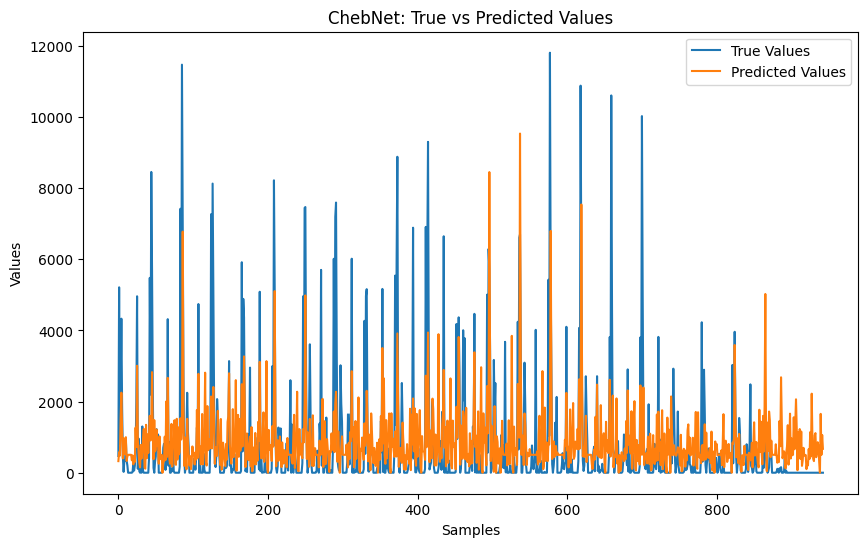

In [ ]:
# from types import MappingProxyType
def train_model(model, criterion, optimizer, data, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        starttime = datetime.datetime.now()
        optimizer.zero_grad()
        outputs = model(data.x_dict, data.edge_index_dict)

        # print(outputs.shape)

        train_outputs = outputs[data['product'].train_mask]
        train_labels = data['product'].y[data['product'].train_mask]

        loss = criterion(train_outputs.squeeze(), train_labels.squeeze())
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        val_loss, _, _ = evaluate_model(model, criterion, data, mask_type='val_mask')

        endtime = datetime.datetime.now()
        epoch_time = (endtime - starttime).seconds

        if wb_log:
            wandb.log({"epoch": epoch+1, "time": epoch_time, "train loss": train_loss, "val loss": val_loss})
        # print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Early Stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            epochs_without_improvement = 0
            print(f'Epoch {epoch}, Epoch Time: {epoch_time}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs')
            if wb_log:
                wandb.summary['Best VAL Loss'] = best_val_loss
            break

    return best_model

def evaluate_model(model, criterion, data, mask_type='valid_mask'):
    model.eval()
    with torch.no_grad():
        outputs = model(data.x_dict, data.edge_index_dict)
        mask = data['product'][mask_type]
        eval_outputs = outputs[mask]
        eval_labels = data['product'].y[mask]
        loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

        all_outputs = eval_outputs.cpu().numpy()
        all_targets = eval_labels.cpu().numpy()

    return loss.item(), all_outputs, all_targets

def test_model(model, criterion, data_loader, scaler_y=None, mask_type='test_mask'):
    with torch.no_grad():
      outputs = model(data.x_dict, data.edge_index_dict)
      mask = data['product'][mask_type]
      eval_outputs = outputs[mask]
      eval_labels = data['product'].y[mask]
      loss = criterion(eval_outputs.squeeze(), eval_labels.squeeze())

      # Truncate negative numbers to zero
      eval_outputs = torch.clamp(eval_outputs, min=0)

      all_outputs = eval_outputs.cpu().numpy()
      all_targets = eval_labels.cpu().numpy()

    loss /= len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if scaler_y is not None:
        # Convert the dimension of y from (n, ) to (n, 1).
        all_outputs = np.expand_dims(all_outputs, axis=1)
        all_targets = np.expand_dims(all_targets, axis=1)
        # print(all_outputs.shape, all_targets.shape)

        all_outputs = scaler_y.inverse_transform(all_outputs)
        all_targets = scaler_y.inverse_transform(all_targets)

    return loss, all_outputs, all_targets

def calculate_errors(predictions, ground_truth):
    # Make sure the input is a numpy array
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = np.mean(np.abs(predictions - ground_truth))
    mse = np.mean((predictions - ground_truth) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((ground_truth - predictions) / (ground_truth+0.000000001))) * 100

    return mae, mse, rmse, mape

set_seed(seed)

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)

# Train model
best_model = train_model(model, criterion, optimizer, data, num_epochs=num_epochs, patience=patience)

# Test model
test_loss, test_outputs, test_targets = test_model(best_model, criterion, data, scaler_y=scaler_y, mask_type='test_mask')
mae, mse, rmse, mape = calculate_errors(test_outputs, test_targets)

# Write metrics in WB
if wb_log:
    wandb.summary['Test Loss'] = test_loss
    wandb.summary['Test MAE'] = mae
    wandb.summary['Test MSE'] = mse
    wandb.summary['Test RMSE'] = rmse
    wandb.summary['Test MAPE'] = mape
    wandb.finish()

print(f'Test Loss: {test_loss}')

# Viz predictions
plt.figure(figsize=(10, 6))
plt.plot(test_targets.flatten(), label='True Values')
plt.plot(test_outputs.flatten(), label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.title('ChebNet: True vs Predicted Values')
plt.show()